In [2]:
from datetime import datetime

In [3]:
from fastai.vision import *
from torchvision.models import vgg16_bn

In [4]:
from src.config.config import *
from src.config.superresgan import *
from src.attributes import *
from src.models.superresgan import *
from src.data.make_dataset import *

# Generator

## Create dataloader for the generator

#### Look at training data

In [3]:
training_data = pd.read_csv(path_trainingset)

In [4]:
training_data.head()

,Image,Mask,is_validation
0,ISIC_0013678.jpg,ISIC_0013678_segmentation.png,True
1,ISIC_0014610.jpg,ISIC_0014610_segmentation.png,True
2,ISIC_0011149.jpg,ISIC_0011149_segmentation.png,True
3,ISIC_0000493.jpg,ISIC_0000493_segmentation.png,False
4,ISIC_0001449.jpg,ISIC_0001449_segmentation.png,False


#### Generator data

In [5]:
#change the format of the training_data dataframe to fit fastai.
img_paths = []

for i, row in training_data.iterrows():
    img_paths.append(path_img + '/' + row['Image'])

data = training_data.copy()
data['Image'] = img_paths
data.head()

,Image,Mask,is_validation
0,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0013678_segmentation.png,True
1,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0014610_segmentation.png,True
2,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0011149_segmentation.png,True
3,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0000493_segmentation.png,False
4,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0001449_segmentation.png,False


In [6]:
src = ImageImageList.from_df(data, path_mask, cols = 1).split_by_rand_pct(0.1, seed=42)

data_gen = (src.label_from_df(cols=0)
       .transform(get_transforms(), size=img_size, tfm_y=True)
       .databunch(bs=32).normalize(imagenet_stats, do_y=True))

data_gen.c = 3

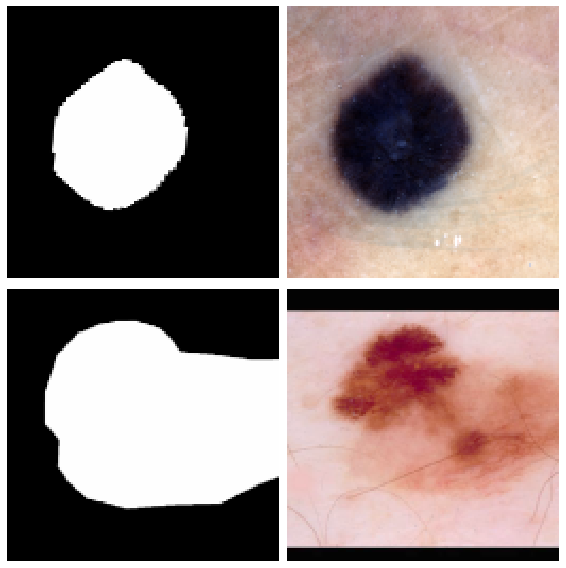

In [7]:
data_gen.show_batch(rows=2)

## Create generator model

In [7]:
arch = models.resnet34
t = data_gen.valid_ds[0][1].data
t = torch.stack([t,t])
base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [8]:
generator = unet_learner(data_gen, arch, wd=weight_decay, loss_func=feat_loss, callback_fns=LossMetrics,
                 blur=True, norm_type=NormType.Weight)

## Work with saved generator model
Want to make a new generator model? skip this part

In [13]:
model_stats = pd.read_csv(path_models + '/model_stats.csv')
model_stats

,Id,Model,Img_size,Batch_size,Epochs,Weight_decay,Num_gen,Date,Time
0,43833e,wgan,128,128,30,0.0,3000,12/10/2019,13:18:34


In [6]:
model_id = 'ecc55e'
model_type = 'superresgan'

In [18]:
generator.model.load_state_dict(torch.load(path_models + '/generator/' + model_type + '/' + model_id + '_a.pth'))

<All keys matched successfully>

## Make your own generator model
Skip this part if you have loaded a model

In [ ]:
model_id = create_model_id(models)
model_type = 'superresgan'

In [8]:
setup_data_directory (model_id, model_type, ['generated_images', 'pretrained_images'])

In [9]:
setup_models_directory(model_type, ['generator', 'critic'])

#### Pretrain generator

In [11]:
gc.collect()

9019

In [12]:
generator.fit_one_cycle(epochs, slice(2e-3), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.860939,3.539132,0.574393,0.321546,0.325078,0.098858,1.045109,1.078712,0.095436,02:21
1,3.468887,3.237928,0.570889,0.312580,0.318698,0.092203,0.886711,0.967280,0.089567,02:19
2,3.213824,3.049121,0.552456,0.314895,0.313352,0.090401,0.745801,0.944090,0.088126,02:19
3,3.000025,2.874575,0.540064,0.309308,0.315990,0.090615,0.609502,0.919162,0.089934,02:16
4,2.816117,2.670480,0.531612,0.297436,0.281760,0.080499,0.536297,0.859883,0.082994,02:17
5,2.712597,2.679947,0.528963,0.301351,0.288544,0.082827,0.530785,0.863602,0.083875,02:15
6,2.692397,2.713976,0.530725,0.304569,0.286432,0.082573,0.556160,0.869916,0.083601,02:15
7,2.674581,2.640756,0.527203,0.299483,0.278710,0.079365,0.525288,0.848507,0.082200,02:19
8,2.646919,2.634588,0.525205,0.299198,0.274893,0.079048,0.520881,0.853158,0.082205,02:25
9,2.612859,2.576858,0.514418,0.296163,0.271345,0.077757,0.506749,0.828754,0.081671,02:15


In [13]:
generator.unfreeze()
generator.fit_one_cycle(epochs, slice(1e-5,2e-3), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.559240,2.574303,0.515092,0.296781,0.268382,0.077510,0.502730,0.832221,0.081587,02:28
1,2.555871,2.568687,0.516064,0.294736,0.270335,0.077616,0.503723,0.824499,0.081714,02:13
2,2.557827,2.573855,0.512860,0.296794,0.268882,0.078049,0.506631,0.828814,0.081826,02:16
3,2.570021,2.587725,0.526718,0.296109,0.269201,0.078405,0.507447,0.827812,0.082033,02:17
4,2.577642,2.597901,0.521451,0.294484,0.273698,0.078604,0.511437,0.836269,0.081957,02:19
5,2.588787,2.609498,0.526996,0.299646,0.271488,0.078488,0.512216,0.838623,0.082042,02:15
6,2.586109,2.609385,0.524086,0.301968,0.274571,0.078859,0.508540,0.839095,0.082265,02:12
7,2.586880,2.583254,0.509790,0.292273,0.272714,0.078300,0.513825,0.834282,0.082072,02:20
8,2.582472,2.569047,0.511938,0.295370,0.271197,0.077752,0.505487,0.825630,0.081672,02:14
9,2.558932,2.536751,0.505877,0.294254,0.267451,0.077259,0.494631,0.815793,0.081485,02:15


#### Save generator model

In [14]:
torch.save(generator.model.state_dict(), path_models + '/generator/' + model_type + '/' + model_id + '_a.pth')

## Save prediction

In [15]:
predict(data_gen.fix_dl.dataset.items, path_gen + '/pretrained_images/' + model_type + '/' + model_id , generator)

[Progress: 1867/1868]

# Critic

## Create dataloader for the critic

#### Look at training data

In [10]:
gen_data = os.listdir(path_gen + '/pretrained_images/' + model_type + '/' + model_id)
org_data = training_data['Image'].tolist()
classes = ['Real', 'Fake']

In [11]:
data_critic = label_data_critic(org_data, gen_data, path_img, path_gen + '/pretrained_images/' + model_type + '/' + model_id, classes)
data_critic.head()

,Filenames,label
0,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
1,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
2,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
3,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
4,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real


#### Critic data

In [12]:
src = ImageList.from_df(path = Path(''), df=data_critic).split_by_rand_pct(0.1, seed=42)
ll = src.label_from_df('label')
data = (ll.transform(get_transforms(), size=128)
       .databunch(bs=32).normalize(imagenet_stats))
data.c = 3

## Create critic model

In [13]:
critic = Learner(data, gan_critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), wd=weight_decay)

## Work with saved critic model
Want to make a new generator model? skip this part

In [20]:
models_stats

NameError: name 'models_stats' is not defined

In [23]:
critic.model.load_state_dict(torch.load(path_models + '/critic/' + model_type + '/' + model_id + '_a.pth'))

<All keys matched successfully>

## Make your own critic model
Skip this part if you have loaded a model

#### Pretrain critic

In [32]:
critic.fit_one_cycle(epochs/5, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.471849,0.334866,0.833807,02:21
1,0.250891,0.076566,0.971675,02:24
2,0.121569,0.045263,0.987411,02:27


#### Save critic

In [33]:
torch.save(critic.model.state_dict(), path_models + '/critic/' + model_type + '/' + model_id + '_a.pth')

PosixPath('../models/superres_critic.pth')

## Work with saved GAN model
Want to make a new generator model? skip this part

In [ ]:
models_stats

In [14]:
generator.model.load_state_dict(torch.load(path_models + '/generator/' + model_type + '/' + model_id + '_b.pth'))
critic.model.load_state_dict(torch.load(path_models + '/critic/' + model_type + '/' + model_id + '_b.pth'))

<All keys matched successfully>

## Create GAN model

In [16]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
gan = GANLearner.from_learners(generator, critic, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                             opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=weight_decay)
gan.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

## Make your own GAN model
Skip this part if you have loaded a model

#### Train GAN model

In [25]:
gan.fit(epochs*20, 1e-4)

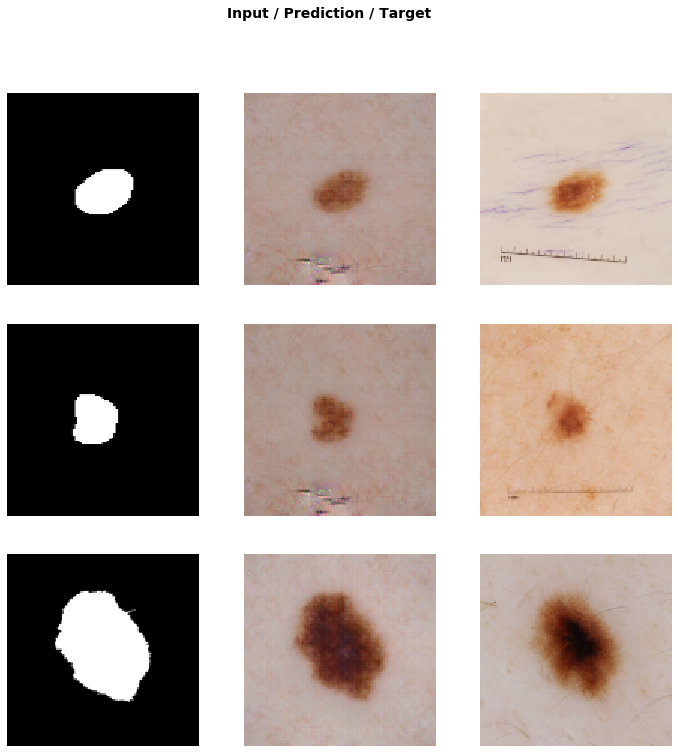

In [19]:
generator.show_results(rows=3)

#### Save model

In [26]:
torch.save(generator.model.state_dict(), path_models + '/generator/' + model_type + '/' + model_id + '_b.pth')
torch.save(critic.model.state_dict(), path_models + '/critic/' + model_type + '/' + model_id + '_b.pth')

#### Predict and save images

In [27]:
models_stats

NameError: name 'models_stats' is not defined

In [15]:
path_gen_masks = path_gen + '/generated_masks/wgan/43833e'
path_gen_images = path_gen + '/generated_images/' + model_type + '/' + model_id
gen_masks = os.listdir(path_gen_masks)

for i in range(len(gen_masks)):
    path = path_gen_masks + '/' + gen_masks[i]
    gen_masks[i] = path


In [16]:
predict(gen_masks, path_gen_images, generator)

[Progress: 3000/3001]

In [17]:
df = pd.DataFrame()
df['Image'] = [f for f in sorted(os.listdir(path_gen_images)) if f.endswith('.jpg')]
df['Mask'] = [f for f in sorted(os.listdir(path_gen_masks)) if f.endswith('.jpg')]
df

,Image,Mask
0,img_gen_00000.jpg,mask_gen_00000.jpg
1,img_gen_00001.jpg,mask_gen_00001.jpg
2,img_gen_00002.jpg,mask_gen_00002.jpg
3,img_gen_00003.jpg,mask_gen_00003.jpg
4,img_gen_00004.jpg,mask_gen_00004.jpg
...,...,...
2995,img_gen_02995.jpg,mask_gen_02995.jpg
2996,img_gen_02996.jpg,mask_gen_02996.jpg
2997,img_gen_02997.jpg,mask_gen_02997.jpg
2998,img_gen_02998.jpg,mask_gen_02998.jpg


In [20]:
# TODO: Sort 

,Image,Mask
0,img_gen_02474.jpg,mask_gen_01684.jpg
1,img_gen_00112.jpg,mask_gen_02339.jpg
2,img_gen_00590.jpg,mask_gen_00535.jpg
3,img_gen_00978.jpg,mask_gen_02429.jpg
4,img_gen_01798.jpg,mask_gen_01642.jpg


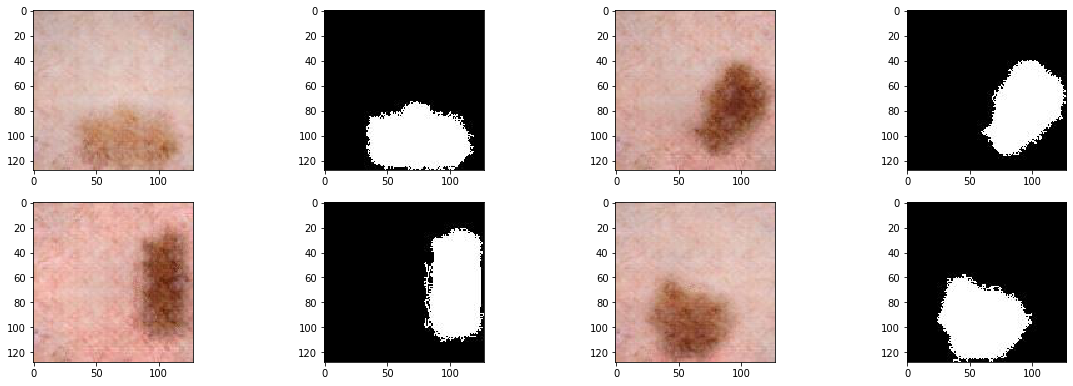

In [18]:
show_batch(df, path_gen_images, path_gen_masks)

#### Save model stats

In [7]:
date = datetime.now().strftime("%d/%m/%Y")
time = datetime.now().strftime("%H:%M:%S")

In [8]:
new_model_stats = pd.DataFrame({'Id': [model_id], 'Model': model_type, 'Img_size': img_size, 'Batch_size': batch_size, 'Epochs': epochs, 'Weight_decay': weight_decay, 'Num_gen': num_gen_mask, 'Date': date, 'Time' : time})

In [9]:
new_model_stats

,Id,Model,Img_size,Batch_size,Epochs,Weight_decay,Num_gen,Date,Time
0,ecc55e,superresgan,128,32,10,0.001,3000,12/10/2019,13:19:38


In [14]:
model_stats = add_model_stats(new_model_stats, model_stats)

In [15]:
model_stats

,Id,Model,Img_size,Batch_size,Epochs,Weight_decay,Num_gen,Date,Time
0,43833e,wgan,128,128,30,0.000,3000,12/10/2019,13:18:34
1,ecc55e,superresgan,128,32,10,0.001,3000,12/10/2019,13:19:38
